<a href="https://colab.research.google.com/github/Belukha9/6884-project/blob/main/6884.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Modules

In [1]:
import numpy as np
import os
import tensorflow as tf
import pandas as pd
import scipy.io
import matplotlib.pyplot as plt
from google.colab import drive

## 1. Load Data

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


### spectra data

In [3]:
file_path = "/content/drive/MyDrive/uterine/aaa_unnormSpec_tb_all_190_2025.csv"
df = pd.read_csv(file_path, header=None)

# 2) Load the 'allWL.mat' file to get the wavelength names
mat_file_path = "/content/drive/MyDrive/uterine/allWL.mat"
mat_data = scipy.io.loadmat(mat_file_path)

In [4]:
# Extract the wavelength information (assuming it's stored under a key like 'allWL')
wavelengths = mat_data['allWL'].flatten()

# Create the full column names
# Column 1: map number
# Column 2: labeling (0=normal uterus, 1=endometrial cancer, 2=fibroid)
# Columns 3-1026: wavelengths (1024 in total)
# Columns 1027-1028: X and Y positions in inches

# Prepare the column names
columns = ['mapnum', 'labeling'] + list(wavelengths) + ['X Position', 'Y Position']

# Step 4: Assign column names to the dataframe
df.columns = columns

# Step 5: Display the dataframe to check the result
print(df.keys)

<bound method NDFrame.keys of        mapnum  labeling  434.187709  435.117867  436.046677  436.974146  \
0           4         1    0.689921    0.695903    0.701522    0.670873   
1           4         1    0.789270    0.795740    0.801853    0.766859   
2           4         1    0.884674    0.891501    0.897986    0.858827   
3           4         1    0.973759    0.980788    0.987528    0.944468   
4           4         1    1.054525    1.061577    1.068438    1.021858   
...       ...       ...         ...         ...         ...         ...   
91840     190         4    1.335107    1.367053    1.370663    1.329167   
91841     190         4    1.332185    1.338028    1.379563    1.340982   
91842     190         4    1.332185    1.335126    1.400331    1.394149   
91843     190         4    1.378929    1.369955    1.382530    1.385287   
91844     190         4    1.364321    1.332223    1.385497    1.376426   

       437.900282  438.825093  439.748585  440.670767  ...  1139.9466

### spcmnum, patientnum, age

In [5]:
# 1) Load the CSV data without headers
file_path = "/content/drive/MyDrive/uterine/header_tb_all_190_2025.csv"
df2 = pd.read_csv(file_path, usecols=["mapnum", "spcmnum", "patientnum"])
print(df2.keys)

<bound method NDFrame.keys of        mapnum  spcmnum  patientnum
0           4        8           4
1           4        8           4
2           4        8           4
3           4        8           4
4           4        8           4
...       ...      ...         ...
91840     190      105          40
91841     190      105          40
91842     190      105          40
91843     190      105          40
91844     190      105          40

[91845 rows x 3 columns]>


In [6]:
df2['mapnum'] = df2['mapnum'].astype(int)

In [7]:
# Check if the sets of 'map number' match exactly
mapnums_df = set(df['mapnum'])
mapnums_df2 = set(df2['mapnum'])

if mapnums_df == mapnums_df2:
    print("All map numbers match between df and df2.")
else:
    print("The set of map numbers does NOT match between df and df2.")
    missing_in_df2 = mapnums_df - mapnums_df2
    missing_in_df = mapnums_df2 - mapnums_df
    if missing_in_df2:
        print(f"Map numbers missing in df2: {missing_in_df2}")
    if missing_in_df:
        print(f"Map numbers missing in df: {missing_in_df}")

All map numbers match between df and df2.


In [8]:
num_map = df2['mapnum'].nunique()
num_spcm = df2['spcmnum'].nunique()
num_patient = df2['patientnum'].nunique()

print(f"Unique mapnum count: {num_map}")
print(f"Unique spcmnum count: {num_spcm}")
print(f"Unique patientnum count: {num_patient}")

Unique mapnum count: 174
Unique spcmnum count: 95
Unique patientnum count: 34


### Data Overview

In [ ]:
summary = (
    df2
    .groupby('labeling', observed=True)[['mapnum','spcmnum','patientnum']]
    .nunique()
    .rename(columns={
        'mapnum':    'unique_mapnum_count',
        'spcmnum':   'unique_spcmnum_count',
        'patientnum':'unique_patientnum_count'
    })
    .sort_index()
)

print(summary)

          unique_mapnum_count  unique_spcmnum_count  unique_patientnum_count
labeling                                                                    
0                          57                    30                       17
1                          35                    21                       13
2                          71                    39                       14
3                           6                     3                        1
4                           8                     4                        1


In [ ]:
# 假设之前已经在 df2 上加过 df 的 labeling 列：
# df2['labeling'] = df['labeling'].values

# 1) 筛出 labeling 为 3 或 4 的行
mask = df2['labeling'].isin([3, 4])

# 2) 只保留 mapnum, spcmnum, patientnum, labeling 四列，并去重、排序
df_special = (
    df2.loc[mask, ['mapnum','spcmnum','patientnum','labeling']]
       .drop_duplicates()
       .sort_values(['labeling','mapnum','spcmnum','patientnum'])
)

# 3) 打印结果
print(df_special.to_string(index=False))


 mapnum  spcmnum  patientnum  labeling
    177       99          39         3
    178       99          39         3
    179      100          39         3
    180      100          39         3
    181      101          39         3
    182      101          39         3
    183      102          40         4
    184      102          40         4
    185      103          40         4
    186      103          40         4
    187      104          40         4
    188      104          40         4
    189      105          40         4
    190      105          40         4


In [ ]:
# 筛选出 mapnum 为 175 或 176 的行
mask = df2['mapnum'].isin([173, 174, 175, 176])
selected = df2.loc[mask, ['mapnum', 'spcmnum', 'patientnum','labeling']].drop_duplicates()

# 打印结果
print(selected.to_string(index=False))


 mapnum  spcmnum  patientnum  labeling
    173       97          38         1
    174       97          38         1
    175       98          39         0
    176       98          39         0


Label Distribution:
labeling
Fibroid               41732
Normal Uterus         27444
Endometrial Cancer    14712
Adenomyosis            4861
Leiomyosarcoma         3096
Name: count, dtype: int64


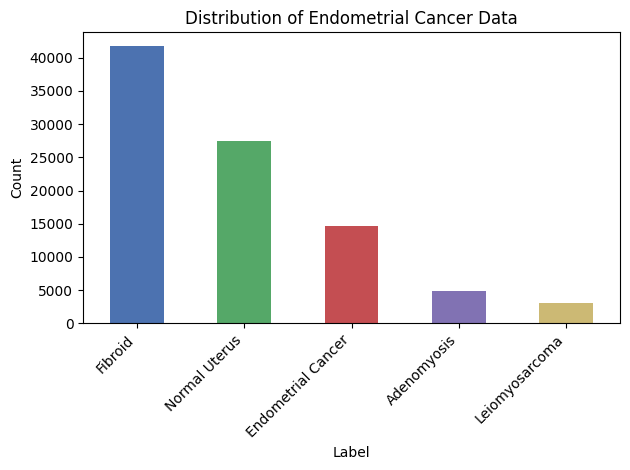

In [ ]:
df.iloc[:, 1].name = "Label"
# label counting
df.iloc[:, 1] = df.iloc[:, 1].astype(int)
label_counts = df.iloc[:, 1].value_counts()
label_counts.index = label_counts.index.astype(int)
label_mapping = {
    0: "Normal Uterus",
    1: "Endometrial Cancer",
    2: "Fibroid",
    3: "Leiomyosarcoma",
    4: "Adenomyosis"
}
label_counts.index = label_counts.index.map(label_mapping)

print("Label Distribution:")
print(label_counts)

colors = ['#4C72B0', '#55A868', '#C44E52', '#8172B3', '#CCB974']

label_counts.plot(
    kind='bar',
    color=colors
)
plt.xlabel("Label")
plt.ylabel("Count")
plt.title("Distribution of Endometrial Cancer Data")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

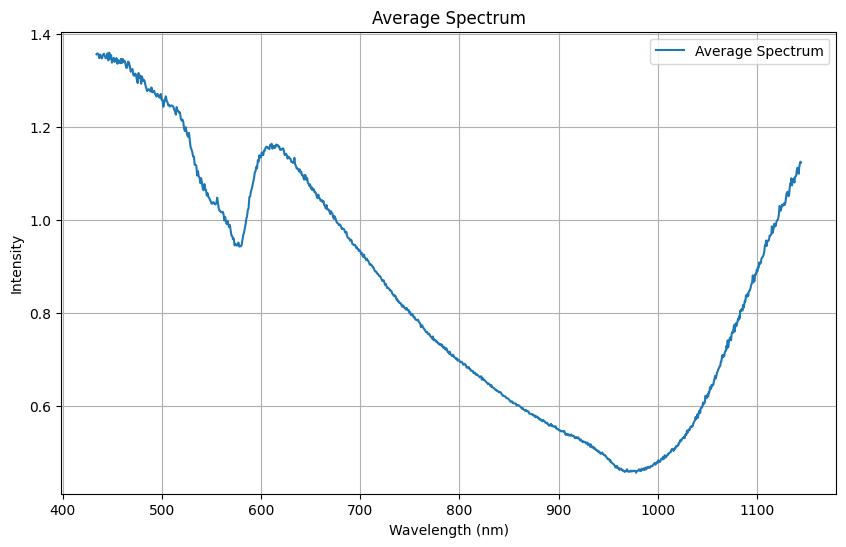

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

spectra = df.iloc[:, 2:-2].values

average_spectrum = np.mean(spectra, axis=0)

plt.figure(figsize=(10, 6))
plt.plot(wavelengths, average_spectrum, label='Average Spectrum')
plt.title('Average Spectrum')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Intensity')
plt.legend()
plt.grid(True)
plt.show()

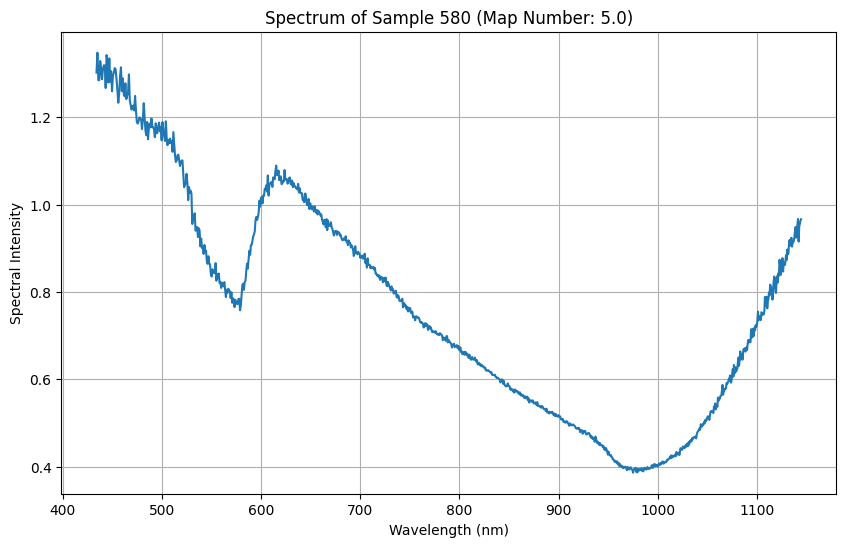

In [ ]:
sample_index = 580

spectrum = df.iloc[sample_index, 2:-2].values
wavelengths = df.columns[2:-2].values

plt.figure(figsize=(10, 6))
plt.plot(wavelengths, spectrum)
plt.title(f"Spectrum of Sample {sample_index} (Map Number: {df.iloc[sample_index]['mapnum']})")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Spectral Intensity")
plt.grid(True)
plt.show()


### Data Preprocessing

In [ ]:
import scipy.signal as signal
import scipy.interpolate as interp
import scipy.io as sio
import matplotlib.pyplot as plt

In [ ]:
# Extract spectral data
wavelength_cols = [col for col in df.columns if isinstance(col, (int, float)) or col.replace('.', '', 1).isdigit()]
wavelengths = np.array([float(col) for col in wavelength_cols])
spectra = df[wavelength_cols].values
print(spectra)

[[0.6899207  0.69590349 0.70152151 ... 0.25353337 0.25176399 0.25507379]
 [0.78927023 0.79573978 0.80185295 ... 0.29021956 0.2881858  0.29176808]
 [0.88467444 0.89150086 0.89798628 ... 0.32534748 0.32305838 0.32687946]
 ...
 [1.33218525 1.33512572 1.40033103 ... 1.16708135 1.11923111 1.11293932]
 [1.37892859 1.36995509 1.38253021 ... 1.14597681 1.1297502  1.14420166]
 [1.3643213  1.33222327 1.38549702 ... 1.16286044 1.10871202 1.12961257]]


In [ ]:
# Step 1: Normalize spectra using Area Under the Curve (AUC)
auc = np.trapz(spectra, wavelengths, axis=1)
normalized_spectra = spectra / auc[:, np.newaxis]

<ipython-input-26-757af97a78af>:2: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(spectra, wavelengths, axis=1)


In [ ]:
# Step 2: Apply low-pass filter (0.05π rad/sample)
b, a = signal.butter(4, 0.05, btype='low', analog=False)
filtered_spectra = signal.filtfilt(b, a, normalized_spectra, axis=1)

In [ ]:
# Step 3: Compute derivative spectra
derivative_spectra = np.gradient(filtered_spectra, wavelengths, axis=1)

In [ ]:
# Step 4: Interpolate to integer wavelengths (500 nm - 1000 nm)
integer_wavelengths = np.arange(500, 1001, 1)
interp_func = interp.interp1d(wavelengths, filtered_spectra, kind='linear', axis=1, fill_value="extrapolate")
interpolated_spectra = interp_func(integer_wavelengths)

In [ ]:
# Create a new DataFrame with processed spectra
processed_df = pd.DataFrame(interpolated_spectra, columns=integer_wavelengths)
processed_df.insert(0, 'labeling', df['labeling'].values)  # Keep labels for classification

In [ ]:
# Save processed data
processed_df.to_csv("/content/drive/MyDrive/uterine/processed_spectra.csv", index=False)

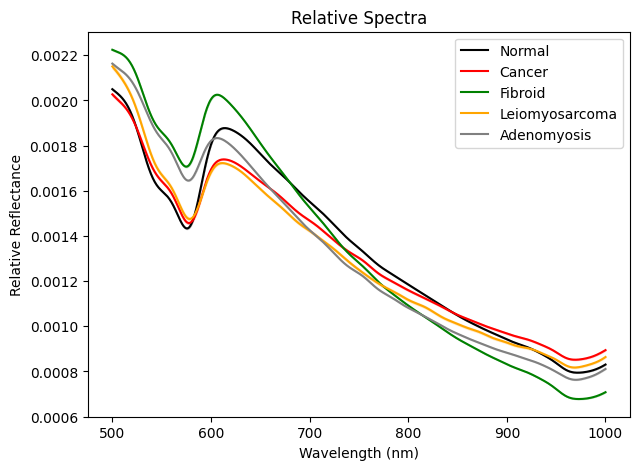

In [ ]:
from scipy.stats import sem

# Load the processed dataset
spectral_data = pd.read_csv("/content/drive/MyDrive/uterine/processed_spectra.csv")

# Extract integer wavelengths
wavelengths = np.arange(500, 1001, 1)

# Extract labels and group data
labels = spectral_data['labeling']
spectra = spectral_data.iloc[:, 1:].values  # Exclude labeling column

# Define groups
group_names = {0: 'Normal', 1: 'Cancer', 2: 'Fibroid', 3: 'Leiomyosarcoma',
    4: 'Adenomyosis'}
colors = {0: 'black', 1: 'red', 2: 'green', 3: 'orange', 4: 'gray'}

# Group data by labels
grouped_data = {label: spectra[labels == label] for label in np.unique(labels)}

# Plot 1: Mean spectra with 95% confidence interval
plt.figure(figsize=(7, 5))

for label, data in grouped_data.items():
    mean_spectrum = np.mean(data, axis=0)
    confidence_interval = sem(data, axis=0) * 1.96  # 95% CI

    plt.plot(wavelengths, mean_spectrum, color=colors[label], label=group_names[label])
    plt.fill_between(wavelengths, mean_spectrum - confidence_interval,
                     mean_spectrum + confidence_interval, color=colors[label], alpha=0.2)

plt.xlabel("Wavelength (nm)")
plt.ylabel("Relative Reflectance")
plt.title("Relative Spectra")
plt.legend()
plt.show()

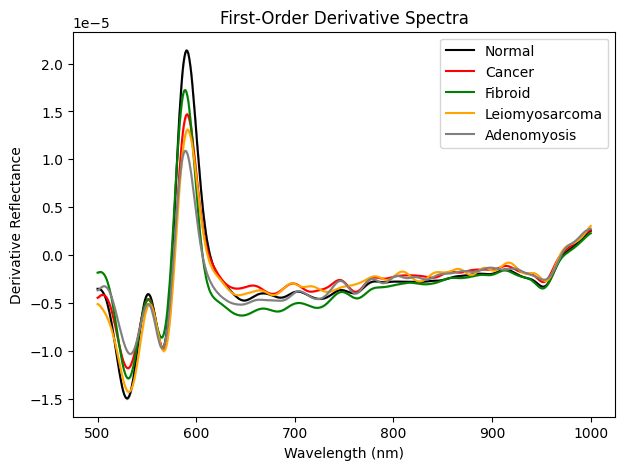

In [ ]:
# Plot 2: First-order derivative spectra
plt.figure(figsize=(7, 5))

for label, data in grouped_data.items():
    derivative_spectra = np.gradient(data, axis=1)  # Compute first derivative
    mean_derivative = np.mean(derivative_spectra, axis=0)
    confidence_interval = sem(derivative_spectra, axis=0) * 1.96  # 95% CI

    plt.plot(wavelengths, mean_derivative, color=colors[label], label=group_names[label])
    plt.fill_between(wavelengths, mean_derivative - confidence_interval,
                     mean_derivative + confidence_interval, color=colors[label], alpha=0.2)

plt.xlabel("Wavelength (nm)")
plt.ylabel("Derivative Reflectance")
plt.title("First-Order Derivative Spectra")
plt.legend()
plt.show()


## 2. Gaussian Classifier

### 2.1 original data

In [5]:
spectral_data = pd.read_csv("/content/drive/MyDrive/uterine/processed_spectra.csv")

In [13]:
# labels
y = spectral_data['labeling'].values.astype(int)

# all wavelength columns
X = spectral_data.drop(columns=['labeling']).values

print(X.shape)  # 应该是 (samples, ~500)
print(y.shape)

(91845, 501)
(91845,)


In [14]:
from sklearn.decomposition import PCA

pca = PCA(n_components=20)
X_pca = pca.fit_transform(X)

print(X_pca.shape)   # → (91845, 20)

(91845, 20)


In [15]:
import numpy as np
from scipy.stats import multivariate_normal

classes = np.unique(y)

def fit_gaussian_model(X_tr, y_tr):
    mu, cov, pi = {}, {}, {}
    for c in classes:
        Xc = X_tr[y_tr == c]
        mu[c] = Xc.mean(axis=0)
        cov[c] = np.cov(Xc, rowvar=False) + 1e-3*np.eye(Xc.shape[1])
        pi[c] = len(Xc) / len(X_tr)
    return mu, cov, pi

def predict_gaussian(X_te, mu, cov, pi):
    log_post = []
    for c in classes:
        rv = multivariate_normal(mean=mu[c], cov=cov[c])
        log_p = np.log(pi[c]) + rv.logpdf(X_te)
        log_post.append(log_p)
    return np.argmax(np.vstack(log_post), axis=0)


In [16]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix

kf = KFold(n_splits=5, shuffle=True, random_state=42)
accs = []

for tr, te in kf.split(X_pca):
    X_tr, X_te = X_pca[tr], X_pca[te]
    y_tr, y_te = y[tr], y[te]

    mu, cov, pi = fit_gaussian_model(X_tr, y_tr)
    y_pred = predict_gaussian(X_te, mu, cov, pi)

    acc = accuracy_score(y_te, y_pred)
    accs.append(acc)

print("Mean 5-fold accuracy:", np.mean(accs))
print("Each fold:", accs)

Mean 5-fold accuracy: 0.45437421743154227
Each fold: [0.4533180902607654, 0.4485818498557352, 0.4562578256845773, 0.45832652839022264, 0.4553867929664108]


### 2.2 first deriavative

In [6]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

spectral_data = pd.read_csv("/content/drive/MyDrive/uterine/processed_spectra.csv")
y = spectral_data['labeling'].values.astype(int)
X0 = spectral_data.drop(columns=['labeling']).values   # 0阶光谱，(N, 501)

# ---- 1) 计算一阶导数特征 ----
# 假设列顺序就是 500–1000nm，间隔 1nm
wavelengths = np.arange(500, 1001, 1)
X_deriv = np.gradient(X0, wavelengths, axis=1)         # (N, 501)

print("X_deriv shape:", X_deriv.shape)

# ---- 2) 标准化（可选，但建议）----
X_mean = X_deriv.mean(axis=0, keepdims=True)
X_std  = X_deriv.std(axis=0, keepdims=True) + 1e-8
X_deriv_norm = (X_deriv - X_mean) / X_std

# ---- 3) PCA 降维 ----
pca = PCA(n_components=20)
X_pca = pca.fit_transform(X_deriv_norm)
print("X_pca shape:", X_pca.shape)


X_deriv shape: (91845, 501)
X_pca shape: (91845, 20)


In [7]:
from scipy.stats import multivariate_normal

classes = np.unique(y)

def fit_gaussian_model(X_tr, y_tr):
    mu, cov, pi = {}, {}, {}
    for c in classes:
        Xc = X_tr[y_tr == c]
        mu[c] = Xc.mean(axis=0)
        cov[c] = np.cov(Xc, rowvar=False) + 1e-3 * np.eye(Xc.shape[1])
        pi[c] = len(Xc) / len(X_tr)
    return mu, cov, pi

def predict_gaussian(X_te, mu, cov, pi):
    log_post = []
    for c in classes:
        rv = multivariate_normal(mean=mu[c], cov=cov[c])
        log_p = np.log(pi[c]) + rv.logpdf(X_te)
        log_post.append(log_p)
    return np.argmax(np.vstack(log_post), axis=0)

# ---- 4) 5-fold CV ----
kf = KFold(n_splits=5, shuffle=True, random_state=42)
accs = []

for tr, te in kf.split(X_pca):
    X_tr, X_te = X_pca[tr], X_pca[te]
    y_tr, y_te = y[tr], y[te]

    mu, cov, pi = fit_gaussian_model(X_tr, y_tr)
    y_pred = predict_gaussian(X_te, mu, cov, pi)

    accs.append(accuracy_score(y_te, y_pred))

print("Mean 5-fold accuracy (1st-derivative features):", np.mean(accs))
print("Each fold:", accs)


Mean 5-fold accuracy (1st-derivative features): 0.8593608797430454
Each fold: [0.8575861505797812, 0.8635200609722903, 0.8576950296695519, 0.8596004137405411, 0.8584027437530622]


## 3. visualize

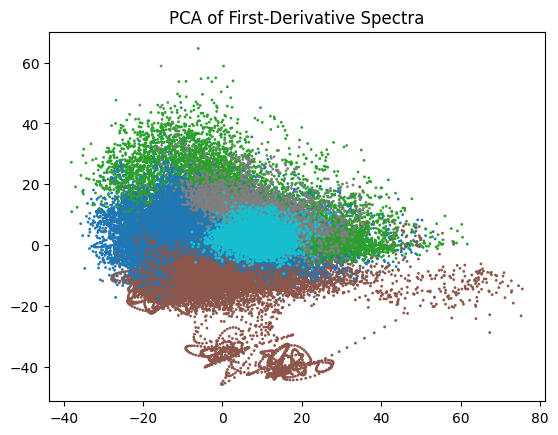

In [10]:
plt.scatter(X_pca[:,0], X_pca[:,1], c=y, cmap='tab10', s=1)
plt.title("PCA of First-Derivative Spectra")
plt.show()

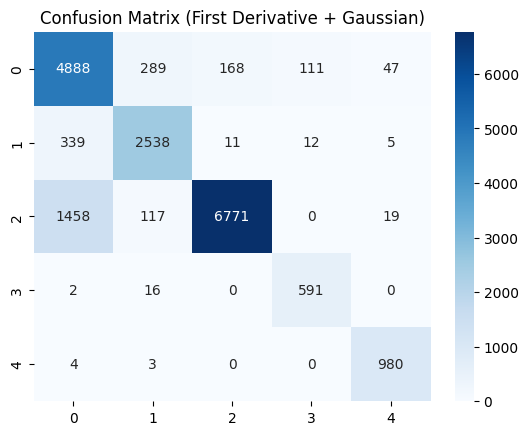

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_te, y_pred, labels=classes)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix (First Derivative + Gaussian)")
plt.show()
